# Importing CRU TS data

The Climate Research Unit gridded Time Series (CRU TS) is a widely used climate dataset on a 0.5° latitude by 0.5° longitude grid over all land domains of the world except Antarctica. The dataset is introduced in this [paper](https://doi.org/10.1038/s41597-020-0453-3).

In [9]:
from netCDF4 import Dataset
import numpy as np
from datetime import datetime, timedelta
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# load data from netCDF file
cru_file = Dataset('../data/CRU-TS/cru_ts4.05.1901.2020.tmx.dat.nc')
print(cru_file)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    Conventions: CF-1.4
    title: CRU TS4.05 Maximum Temperature
    institution: Data held at British Atmospheric Data Centre, RAL, UK.
    source: Run ID = 2103051243. Data generated from:TMX derived from gridded TMP & DTR absolutes, DTR in turn derived from tmn.2103041709.dtb, tmx.2103041709.dtb
    history: Fri  5 Mar 17:13:42 GMT 2021 : User harry : Program makegridsauto.for called by update.for
    references: Information on the data is available at http://badc.nerc.ac.uk/data/cru/
    comment: Access to these data is available to any registered CEDA user.
    contact: support@ceda.ac.uk
    dimensions(sizes): lon(720), lat(360), time(1440)
    variables(dimensions): float32 lon(lon), float32 lat(lat), float32 time(time), float32 tmx(time, lat, lon), int32 stn(time, lat, lon)
    groups: 


### Explore netCDF file

In [11]:
# variable information
cru_vars = [var for var in cru_file.variables]
for var in cru_vars:
    print('variable:', cru_file.variables[var],'\n')

variable: <class 'netCDF4._netCDF4.Variable'>
float32 lon(lon)
    long_name: longitude
    units: degrees_east
unlimited dimensions: 
current shape = (720,)
filling on, default _FillValue of 9.969209968386869e+36 used 

variable: <class 'netCDF4._netCDF4.Variable'>
float32 lat(lat)
    long_name: latitude
    units: degrees_north
unlimited dimensions: 
current shape = (360,)
filling on, default _FillValue of 9.969209968386869e+36 used 

variable: <class 'netCDF4._netCDF4.Variable'>
float32 time(time)
    long_name: time
    units: days since 1900-1-1
    calendar: gregorian
unlimited dimensions: time
current shape = (1440,)
filling on, default _FillValue of 9.969209968386869e+36 used 

variable: <class 'netCDF4._netCDF4.Variable'>
float32 tmx(time, lat, lon)
    long_name: near-surface temperature maximum
    units: degrees Celsius
    correlation_decay_distance: 1200.0
    _FillValue: 9.96921e+36
    missing_value: 9.96921e+36
unlimited dimensions: time
current shape = (1440, 360, 72

In [12]:
# get the data (except tmp, too much data for now)
cru_lon = cru_file.variables['lon'][:]
cru_lat = cru_file.variables['lat'][:]
cru_time = cru_file.variables['time'][:]

print('time:')
print(cru_time)
print('lon:')
print(cru_lon[:10])
print('lat:')
print(cru_lat[:10])

time:
[  380.   410.   439. ... 44118. 44149. 44179.]
lon:
[-179.75 -179.25 -178.75 -178.25 -177.75 -177.25 -176.75 -176.25 -175.75
 -175.25]
lat:
[-89.75 -89.25 -88.75 -88.25 -87.75 -87.25 -86.75 -86.25 -85.75 -85.25]


The material was collected at the Biological Station Fringilla, a field station of the Zoological Institute of the Russian Academy of Sciences, located at 55°05'N, 20°44'E. This is equal to 55.08°N, 20.73°E. The closest grid point is therefore at **55.25°N, 20.75°E**, which, unfortunately, is located in the sea. So let's have a look at the other grid points.

*(Remember: 1 deg ° = 60 min)*

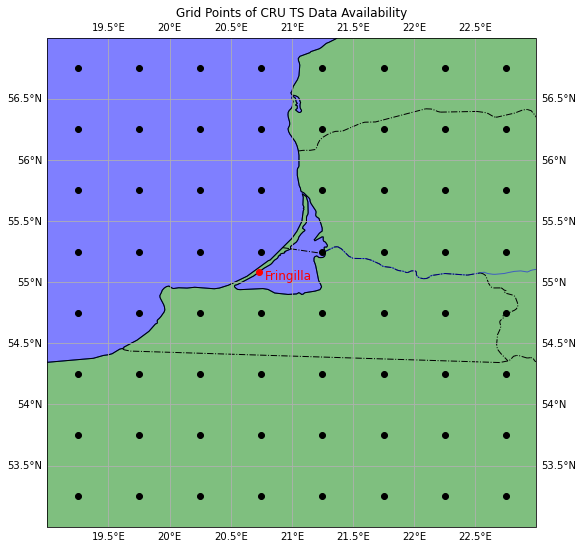

In [13]:
# let's plot the grid points around Kaliningrad
fig = plt.figure(figsize=(16,9))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([19, 23, 53, 57])
ax.add_feature(cfeature.BORDERS, ls='-.')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, color='green', alpha=0.5)
ax.add_feature(cfeature.OCEAN, color='blue', alpha=0.5)
ax.add_feature(cfeature.RIVERS, color='blue', alpha=0.5)
ax.gridlines(draw_labels=True)
#ax.coastlines()
#ax.stock_img()

# create mesh from lon & lat
xlon, ylat = np.meshgrid(cru_lon, cru_lat)
ax.scatter(xlon, ylat, c='k')
ax.plot(20.73, 55.08, 'ro')
ax.text(20.78, 55.02, 'Fringilla', fontsize=12, color='r')
ax.set_title('Grid Points of CRU TS Data Availability')

plt.show()

Time variable is stored as days since 1900-1-1, let's convert it to an actual date.

In [14]:
cru_date = []
start = datetime(1900,1,1)
for i, time in enumerate(cru_time):
    delta = timedelta(int(cru_time[i]))
    cru_date.append(start + delta)

# and define period of years
yfirst = 1998
ylast = 2020
yrs = np.arange(1998, 2020+1)


Let's define the functions for data processing...

In [15]:
# get indices of specific grid point
def get_index(lon, lat):
    for i, llon in enumerate(cru_lon):
        if llon == lon:
            print('index:',i)
            print('value:',cru_lon[i])
            ilon = i
    for i, llat in enumerate(cru_lat):
        if llat == lat:
            print('index:',i)
            print('value:',cru_lat[i])
            ilat = i
    return ilon, ilat

# get tmp data at single grid point
def get_tmp(lon, lat):
    cru_tmp = cru_file.variables['tmx'][:,lat,lon]
    print('tmp:')
    print(cru_tmp[1400:1410])
    return cru_tmp

# extract tmp in april from data
def tmp_in_april(tmp):
    apr_tmp = np.zeros(len(yrs))
    j = 0
    for i in range(len(tmp)):
        # "cru_date" and "cru_tmp" have same shape of (1440,)
        if cru_date[i].year >= yfirst and cru_date[i].month == 4:
            apr_tmp[j] = tmp[i]
            j += 1        
    return apr_tmp

# compute mean tmp from 1st april to 31st October
def mean_tmp_per_year(tmp):
    yr_tmp = np.zeros(len(yrs))
    j = 0
    for i in range(len(tmp)):
        # "cru_date" and "cru_tmp" have same shape of (1440,)
        if cru_date[i].year == yrs[j] and cru_date[i].month == 4:
            yr_tmp[j] = np.mean(tmp[i:i+7])
            if yrs[j] == 2020:
                break
            j += 1
    return yr_tmp

Compute temperature in April and yearly mean.

In [16]:
# define grid points
lon1, lat1 = 21.25, 55.25
lon2, lat2 = 20.75, 54.75

ilon1, ilat1 = get_index(lon1, lat1)
ilon2, ilat2 = get_index(lon2, lat2)

tmp1 = get_tmp(ilon1, ilat1)
tmp2 = get_tmp(ilon2, ilat2)

apr_tmp1 = tmp_in_april(tmp1)
apr_tmp2 = tmp_in_april(tmp2)

yr_tmp1 = mean_tmp_per_year(tmp1)
yr_tmp2 = mean_tmp_per_year(tmp2)



index: 402
value: 21.25
index: 290
value: 55.25
index: 401
value: 20.75
index: 289
value: 54.75
tmp:
[17.        11.3        6.8        4.1        1.3000001 -1.8000001
  2.3       14.7       21.6       22.6      ]
tmp:
[17.        11.1        6.4        3.9        1.4       -2.1000001
  2.6000001 15.        21.9       22.7      ]


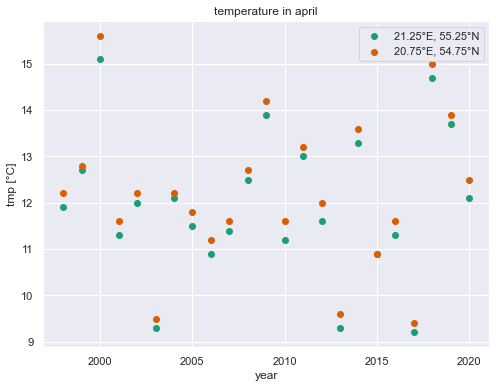

In [17]:
# plotting
sns.set_theme(
    style="darkgrid",
    color_codes=True,
    palette='Dark2',
)
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(yrs, apr_tmp1, label=f'{lon1}°E, {lat1}°N')
ax.scatter(yrs, apr_tmp2, label=f'{lon2}°E, {lat2}°N')
ax.set_xlabel('year')
ax.set_ylabel('tmp [°C]')
ax.set_title('temperature in april')
ax.legend(loc='upper right')
plt.show()

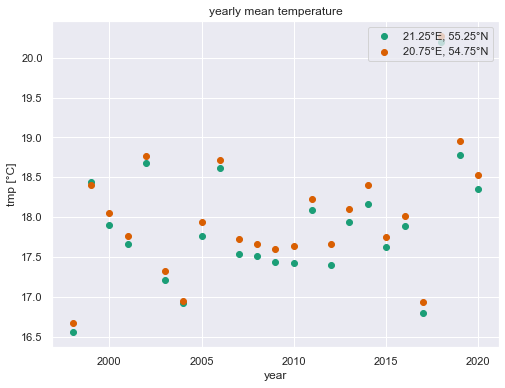

In [18]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(yrs, yr_tmp1, label=f'{lon1}°E, {lat1}°N')
ax.scatter(yrs, yr_tmp2, label=f'{lon2}°E, {lat2}°N')
ax.set_xlabel('year')
ax.set_ylabel('tmp [°C]')
ax.set_title('yearly mean temperature')
ax.legend(loc='upper right')
plt.show()

In [19]:
# save tmp from cru ts dataset
# https://ipython.org/ipython-doc/rel-0.12/config/extensions/storemagic.html
cru_tmp_aprl = apr_tmp1
%store cru_tmp_aprl
cru_tmp_yr = yr_tmp1
%store cru_tmp_yr

Stored 'cru_tmp_aprl' (ndarray)
Stored 'cru_tmp_yr' (ndarray)
